In [1]:
!pip install pydicom
import pydicom as dicom

     |████████████████████████████████| 35.5MB 25.1MB/s 


In [2]:
import numpy as np
import tensorflow.compat.v1 as tf
import cv2
import glob
import matplotlib.pyplot as plt
import scipy

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
#load train data
tf.disable_v2_behavior()
seed = 0
eps = 1e-16
rng = np.random.RandomState(seed)
tf.set_random_seed(seed)
np.seterr(all='raise')

data_path = '/content/drive/My Drive/AML_assn1/ProcessedData/'
Xs_sup = []
ys_sup = []

Xs_val = []
ys_val = []

Xs_unsup = []
img_files = sorted(glob.glob(data_path + 'input/*.dcm'))
gti_files = sorted(glob.glob(data_path + 'gt_icontour/*.png'))
gto_files = sorted(glob.glob(data_path + 'gt_ocontour/*.png'))

unsup_files = sorted(glob.glob(data_path + 'no_gt_input/*.dcm'))
rand_nums = np.random.randint(0, 4, size=len(img_files))
cnt = 0
for dcm_file in img_files:
  ds = dicom.dcmread(dcm_file)
  img_data = np.array(ds.pixel_array)
  img_data = np.float32(img_data)/np.max(img_data)
  img_data = np.expand_dims(img_data, axis=-1)
  if img_data.shape[0]<img_data.shape[1]:
    img_data = np.transpose(img_data, axes=(1, 0, 2))
  if rand_nums[cnt]>0:
    Xs_sup.append(img_data)
  else:
    Xs_val.append(img_data)
  cnt = cnt + 1

for i in range(len(gti_files)):
  gti_file = gti_files[i]
  gto_file = gto_files[i]
  
  im_icontour = cv2.imread(gti_file, cv2.IMREAD_GRAYSCALE)
  im_ocontour = cv2.imread(gto_file, cv2.IMREAD_GRAYSCALE)

  im_icontour = np.float32(im_icontour)/np.max(im_icontour)
  im_ocontour = np.float32(im_ocontour)/np.max(im_ocontour)
  
  im_icontour = np.expand_dims(im_icontour, axis=-1)
  im_ocontour = np.expand_dims(im_ocontour, axis=-1)

  im_contour = np.concatenate((im_icontour, im_ocontour), axis=2)
  if im_contour.shape[0]<im_contour.shape[1]:
    im_contour = np.transpose(im_contour, axes=(1, 0, 2))
  if rand_nums[i]>0:
    ys_sup.append(im_contour)
  else:
    ys_val.append(im_contour)


In [5]:
#load test data
data_path = '/content/drive/My Drive/AML_assn1/ProcessedTest1Data/'
Xs_test = []
ys_test = []

test_img_files = sorted(glob.glob(data_path + 'input/*.dcm'))
test_gti_files = sorted(glob.glob(data_path + 'gt_icontour/*.png'))
test_gto_files = sorted(glob.glob(data_path + 'gt_ocontour/*.png'))

for dcm_file in test_img_files:
  ds = dicom.dcmread(dcm_file)
  img_data = np.array(ds.pixel_array)
  img_data = np.float32(img_data)/np.max(img_data)
  img_data = np.expand_dims(img_data, axis=-1)
  if img_data.shape[0]<img_data.shape[1]:
    img_data = np.transpose(img_data, axes=(1, 0, 2))
  Xs_test.append(img_data)

for i in range(len(test_gti_files)):
  gti_file = test_gti_files[i]
  gto_file = test_gto_files[i]
  
  im_icontour = cv2.imread(gti_file, cv2.IMREAD_GRAYSCALE)
  im_ocontour = cv2.imread(gto_file, cv2.IMREAD_GRAYSCALE)

  im_icontour = np.float32(im_icontour)/np.max(im_icontour)
  im_ocontour = np.float32(im_ocontour)/np.max(im_ocontour)
  
  im_icontour = np.expand_dims(im_icontour, axis=-1)
  im_ocontour = np.expand_dims(im_ocontour, axis=-1)

  im_contour = np.concatenate((im_icontour, im_ocontour), axis=2)
  if im_contour.shape[0]<im_contour.shape[1]:
    im_contour = np.transpose(im_contour, axes=(1, 0, 2))
  ys_test.append(im_contour)

In [ ]:
#augment data with lr and ud flips (use np.fliplr() and np.flipud())
#for i in range(len(Xs_sup)):
#  in_im = Xs_sup[i]
#  gt_im = ys_sup[i]
#  in_flip1 = np.fliplr(in_im)
#  gt_flip1 = np.fliplr(gt_im)
#
#  in_flip2 = np.flipud(in_im)
#  gt_flip2 = np.flipud(gt_im)
#
#  in_flip3 = np.flipud(in_flip1)
#  gt_flip3 = np.flipud(gt_flip1)
#
#  Xs_sup.append(in_flip1)
#  Xs_sup.append(in_flip2)
#  Xs_sup.append(in_flip3)
#
#  ys_sup.append(gt_flip1)
#  ys_sup.append(gt_flip2)
#  ys_sup.append(gt_flip3)

#not using

In [16]:
#augment data with rotation, oversample small ground truth data
times_to_augment = 4
for t_aug in range(times_to_augment):
  for i in range(len(Xs_sup)):
    in_im = Xs_sup[i]
    gt_im = ys_sup[i]
    gt_area = 100*np.mean(gt_im)
    toss = np.random.randint(0, 10)
    if gt_area<=4 and toss<6:
      rotval = np.random.randint(-30, 31)
      in_im_rot = scipy.ndimage.rotate(in_im, rotval, reshape=False, mode='reflect')
      gt_im_rot = scipy.ndimage.rotate(gt_im, rotval, reshape=False, mode='reflect')
      Xs_sup.append(in_im_rot)
      ys_sup.append(gt_im_rot)
    #if gt_area>2 and gt_area<=4 and toss<4:
    #  rotval = np.random.randint(-15, 16)
    #  in_im_rot = scipy.ndimage.rotate(in_im, rotval, reshape=False, mode='reflect')
    #  gt_im_rot = scipy.ndimage.rotate(gt_im, rotval, reshape=False, mode='reflect')
    #  Xs_sup.append(in_im_rot)
    #  ys_sup.append(gt_im_rot)
    if gt_area>4 and toss <3:
      rotval = np.random.randint(-30, 31)
      in_im_rot = scipy.ndimage.rotate(in_im, rotval, reshape=False, mode='reflect')
      gt_im_rot = scipy.ndimage.rotate(gt_im, rotval, reshape=False, mode='reflect')
      Xs_sup.append(in_im_rot)
      ys_sup.append(gt_im_rot)

In [17]:
print(len(ys_sup))
print(len(Xs_sup))

print(len(Xs_val))

print(Xs_sup[0].shape)
print(ys_sup[0].shape)

730
730
62
(256, 216, 1)
(256, 216, 2)


In [22]:
#define model
X_in = tf.placeholder('float', [None, Xs_sup[0].shape[0], Xs_sup[0].shape[1], Xs_sup[0].shape[2]])
y_gt = tf.placeholder('float', [None, ys_sup[0].shape[0], ys_sup[0].shape[1], ys_sup[0].shape[2]])

conv1 = tf.layers.conv2d(X_in, 16, 5, padding='same', activation='relu', kernel_initializer='he_normal')
pool1 = tf.nn.max_pool(conv1, 2, 2, 'SAME', name='pool1')
conv2 = tf.layers.conv2d(pool1, 32, 5, padding='same', activation='relu', kernel_initializer='he_normal')
pool2 = tf.nn.max_pool(conv2, 2, 2, 'SAME', name='pool2')
conv3 = tf.layers.conv2d(pool2, 64, 5, padding='same', activation='relu', kernel_initializer='he_normal')
pool3 = tf.nn.max_pool(conv3, 2, 2, 'SAME', name='pool3')

convmid = tf.layers.conv2d(pool3, 128, 5, padding='same', activation='relu', kernel_initializer='he_normal')

upsamp1 = tf.image.resize_nearest_neighbor(convmid, [conv3.shape[1], conv3.shape[2]], True, name='upsamp1')
concat1 = tf.concat([upsamp1, conv3], axis=3, name='concat1')
conv4 = tf.layers.conv2d(concat1, 32, 3, padding='same', activation='relu', kernel_initializer='he_normal')

upsamp2 = tf.image.resize_nearest_neighbor(conv4, [conv2.shape[1], conv2.shape[2]], True, name='upsamp2')
concat2 = tf.concat([upsamp2, conv2], axis=3, name='concat2')
conv5 = tf.layers.conv2d(concat2, 16, 3, padding='same', activation='relu', kernel_initializer='he_normal')

upsamp3 = tf.image.resize_nearest_neighbor(conv5, [conv1.shape[1], conv1.shape[2]], True, name='upsamp3')
concat3 = tf.concat([upsamp3, conv1], axis=3, name='concat3')
out = tf.layers.conv2d(concat3, 2, 3, padding='same', activation='sigmoid', kernel_initializer='he_normal')


In [10]:
#model with regularization
'''
lambda_l2 = 0.04

X_in = tf.placeholder('float', [1, Xs_sup[0].shape[0], Xs_sup[0].shape[1], Xs_sup[0].shape[2]])
y_gt = tf.placeholder('float', [1, ys_sup[0].shape[0], ys_sup[0].shape[1], ys_sup[0].shape[2]])

conv1 = tf.layers.conv2d(X_in, 16, 5, padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(lambda_l2))
conv1 = tf.layers.batch_normalization(conv1)
pool1 = tf.nn.max_pool(conv1, 2, 2, 'SAME', name='pool1')

conv2 = tf.layers.conv2d(pool1, 32, 5, padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(lambda_l2))
conv2 = tf.layers.batch_normalization(conv2)
pool2 = tf.nn.max_pool(conv2, 2, 2, 'SAME', name='pool2')

conv3 = tf.layers.conv2d(pool2, 64, 5, padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(lambda_l2))
conv3 = tf.layers.batch_normalization(conv3)
conv3 = tf.nn.dropout(conv3, keep_prob=0.55)
pool3 = tf.nn.max_pool(conv3, 2, 2, 'SAME', name='pool3')


upsamp1 = tf.image.resize_nearest_neighbor(pool3, [conv3.shape[1], conv3.shape[2]], True, name='upsamp1')
concat1 = tf.concat([upsamp1, conv3], axis=3, name='concat1')
conv4 = tf.layers.conv2d(concat1, 32, 3, padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(lambda_l2))
conv4 = tf.layers.batch_normalization(conv4)
conv4 = tf.nn.dropout(conv4, keep_prob=0.55)

upsamp2 = tf.image.resize_nearest_neighbor(conv4, [conv2.shape[1], conv2.shape[2]], True, name='upsamp2')
concat2 = tf.concat([upsamp2, conv2], axis=3, name='concat2')
conv5 = tf.layers.conv2d(concat2, 16, 3, padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(lambda_l2))
conv5 = tf.layers.batch_normalization(conv5)

upsamp3 = tf.image.resize_nearest_neighbor(conv5, [conv1.shape[1], conv1.shape[2]], True, name='upsamp3')
concat3 = tf.concat([upsamp3, conv1], axis=3, name='concat3')
out = tf.layers.conv2d(concat3, 2, 3, padding='same', activation='sigmoid', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(lambda_l2))
'''


Define the loss function

In [23]:
lambda_ce = 1
lambda_dice = 0.25
lambda_inv_dice = 0.75
lambda_reg = 0

In [24]:
inv_out = 1-out
inv_gt = 1-y_gt
L_ce = tf.reduce_mean(-y_gt*tf.log(out + eps) - inv_gt*tf.log(inv_out + eps))
#L_ce = tf.reduce_sum(-y_gt*tf.log(out + eps))
#L_ce = tf.reduce_sum(-inv_gt*tf.log(inv_out + eps))
L_dice = 1 - (tf.reduce_sum(2*out*y_gt) + eps)/(tf.reduce_sum(out + y_gt) + eps)
L_inv_dice = 1 - (tf.reduce_sum(2*inv_out*inv_gt) + eps)/(tf.reduce_sum(inv_out + inv_gt) + eps)
L_reg = tf.reduce_mean(tf.nn.relu(out[:,:,:,0]-out[:,:,:,1]))

loss = lambda_ce*L_ce + lambda_dice*L_dice + lambda_inv_dice*L_inv_dice + lambda_reg*L_reg

optimizer = tf.train.AdamOptimizer()
train_op = optimizer.minimize(loss)

Run training code

In [21]:
def compute_iou(out_contour_im, gt_contour_im):
  #both inputs are binary segmentations
  intersection = np.float64(np.sum(gt_contour_im*out_contour_im))
  union = np.float64(np.sum(np.clip(gt_contour_im + out_contour_im, 0, 1)))
  return np.float32((intersection)/(union))

In [ ]:
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)
epochs = 31
loss_values = []
train_iou_values = []

test_loss_values = []
test_iou_values = []

batch_size = 1
data_size = len(Xs_sup)
#test_size = len(Xs_test)
test_size = len(Xs_val)

Xs_sup_array = np.array(Xs_sup)
ys_sup_array = np.array(ys_sup)

#Xs_test_array = np.array(Xs_test)
#ys_test_array = np.array(ys_test)

Xs_test_array = np.array(Xs_val)
ys_test_array = np.array(ys_val)

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
  sess.run(tf.global_variables_initializer())
  for e in range(epochs):
    epoch_losses = []
    epoch_ious = []
    rand_perm = rng.permutation(len(Xs_sup))
    Xs_sup_array = Xs_sup_array[rand_perm]
    ys_sup_array = ys_sup_array[rand_perm]
    num_batches = data_size//batch_size
    for b in range(num_batches):
      in_batch = Xs_sup_array[b*batch_size:(b+1)*batch_size]
      gt_batch = ys_sup_array[b*batch_size:(b+1)*batch_size]
      gt_area = 100*np.mean(gt_batch)

      #switching loss
      #if gt_area>4:
      #  lambda_inv_dice = 0.25
      #  lambda_dice = 0.75
      #else:
      #  lambda_inv_dice = 0.75
      #  lambda_dice = 0.25

      #print(in_batch.shape)
      #print(gt_batch.shape)
      #print(in_batch.dtype)
      #print(gt_batch.dtype)
      feeds = {X_in: in_batch, y_gt: gt_batch}
      out_im, loss_val, _ = sess.run([out, L_dice, train_op], feed_dict=feeds)
      out_contour_im = np.copy(out_im)
      out_contour_im[out_contour_im>=0.5] = 1
      out_contour_im[out_contour_im<0.5] = 0
      batch_iou = compute_iou(out_contour_im, gt_batch)
      epoch_ious.append(batch_iou)
      epoch_losses.append(loss_val)
    if e%3 == 0:
      test_epoch_losses = []
      test_epoch_ious = []
      #rand_perm = rng.permutation(len(Xs_test))
      rand_perm = rng.permutation(len(Xs_val))
      Xs_test_array = Xs_test_array[rand_perm]
      ys_test_array = ys_test_array[rand_perm]
      for tno in range(test_size):
        test_in_batch = Xs_test_array[tno:tno+1]
        test_gt_batch = ys_test_array[tno:tno+1]
        feeds = {X_in: test_in_batch, y_gt: test_gt_batch}
        test_out_im, test_loss_val = sess.run([out, L_dice], feed_dict=feeds)
        test_out_contour_im = np.copy(test_out_im)
        test_out_contour_im[test_out_contour_im>=0.5] = 1
        test_out_contour_im[test_out_contour_im<0.5] = 0
        test_batch_iou = compute_iou(test_out_contour_im, test_gt_batch)
        test_epoch_ious.append(test_batch_iou)
        test_epoch_losses.append(test_loss_val)
      test_epoch_mean_loss = np.mean(np.array(test_epoch_losses))
      test_epoch_mean_iou  = np.mean(np.array(test_epoch_ious))
      print('Val')
      #print('Test')
      print("epoch loss : " + str(test_epoch_mean_loss))
      print("epoch iou : " + str(test_epoch_mean_iou))
      test_loss_values.append(test_epoch_mean_loss)
      test_iou_values.append(test_epoch_mean_iou)

    epoch_mean_loss = np.mean(np.array(epoch_losses))
    epoch_mean_iou  = np.mean(np.array(epoch_ious))
    print('epoch : ' + str(e))
    print("epoch loss : " + str(epoch_mean_loss))
    print("epoch iou : " + str(epoch_mean_iou))
    loss_values.append(epoch_mean_loss)
    train_iou_values.append(epoch_mean_iou)

Val
epoch loss : 0.46924388
epoch iou : 0.4511294
epoch : 0
epoch loss : 0.73101556
epoch iou : 0.16588745
epoch : 1
epoch loss : 0.42913422
epoch iou : 0.4945989
epoch : 2
epoch loss : 0.26914918
epoch iou : 0.6589541
Val
epoch loss : 0.20049354
epoch iou : 0.7230889
epoch : 3
epoch loss : 0.19451432
epoch iou : 0.7369632
epoch : 4
epoch loss : 0.15764128
epoch iou : 0.77956223
epoch : 5
epoch loss : 0.13065116
epoch iou : 0.81154084
Val
epoch loss : 0.32952517
epoch iou : 0.55390894
epoch : 6
epoch loss : 0.107138544
epoch iou : 0.8382212
epoch : 7
epoch loss : 0.10553083
epoch iou : 0.84086126
epoch : 8
epoch loss : 0.07694628
epoch iou : 0.8778467
Val
epoch loss : 0.17821719
epoch iou : 0.7345199
epoch : 9
epoch loss : 0.095153764
epoch iou : 0.85486424
epoch : 10
epoch loss : 0.07520927
epoch iou : 0.87997895
epoch : 11
epoch loss : 0.06021815
epoch iou : 0.9006734
Val
epoch loss : 0.17320597
epoch iou : 0.7429226
epoch : 12
epoch loss : 0.060342547
epoch iou : 0.9007772
epoch : 1

test iou values
[0.006638861, 0.3866656, 0.49375263, 0.42392236, 0.5129047, 0.4678906, 0.45340016, 0.508986, 0.5199543]
test loss values
[0.83646226, 0.5014468, 0.40537336, 0.45682147, 0.3748459, 0.41818553, 0.4274872, 0.37709272, 0.3650243]
train iou values
[0.010828046, 0.2444794, 0.418756, 0.50849074, 0.57024765, 0.61915284, 0.65281314, 0.70009685, 0.72664034, 0.7405373, 0.76504993, 0.77568024, 0.791789, 0.80623424, 0.8150993, 0.82690775, 0.8222191, 0.8433772, 0.84796387, 0.85172576, 0.8589776, 0.8655936, 0.87511235, 0.8516477, 0.8817982]
train loss values
[0.831693, 0.6687214, 0.5064969, 0.41419098, 0.3507545, 0.3031546, 0.26979858, 0.22748621, 0.20386435, 0.18900499, 0.16912971, 0.16046499, 0.14643367, 0.13467313, 0.12818669, 0.1175903, 0.123382494, 0.105044685, 0.101640336, 0.09847648, 0.092830434, 0.08784521, 0.080675915, 0.09956059, 0.07564427]


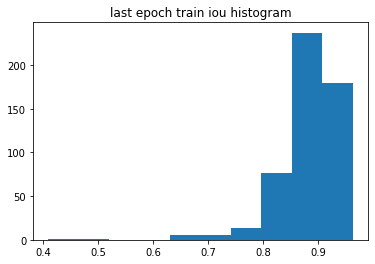

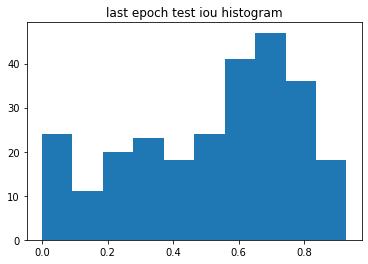

In [ ]:
#print('test iou values')
#print(test_iou_values)

#print('test loss values')
#print(test_loss_values)

print('val iou values')
print(test_iou_values)

#print('val loss values')
#print(test_loss_values)

print('train iou values')
print(train_iou_values)

print('train loss values')
print(loss_values)

train_last_epoch_iou_hist, bins = np.histogram(np.array(epoch_ious))
plt.figure()
plt.hist(np.array(epoch_ious))
plt.title('last epoch train iou histogram')
plt.show()

#print('last epoch train loss values')
#print(epoch_losses)

test_last_epoch_iou_hist, bins = np.histogram(np.array(test_epoch_ious))
plt.figure()
plt.hist(np.array(test_epoch_ious))
#plt.title('last epoch test iou histogram')
plt.title('last epoch val iou histogram')
plt.show()

#print('last epoch test loss values')
#print(test_epoch_losses)



0.8724613
0.92872155


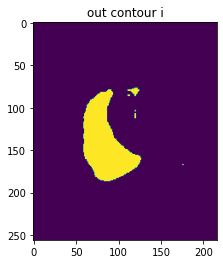

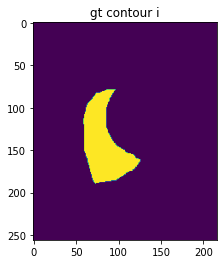

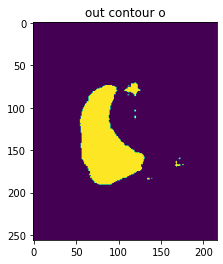

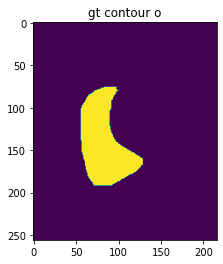

In [ ]:

plt.figure()
plt.title('out contour i')
plt.imshow(test_out_contour_im[0,:,:,0])

plt.figure()
plt.title('gt contour i')
plt.imshow(test_gt_batch[0,:,:,0])

plt.figure()
plt.title('out contour o')
plt.imshow(test_out_contour_im[0,:,:,1])

plt.figure()
plt.title('gt contour o')
plt.imshow(test_gt_batch[0,:,:,1])


print(test_batch_iou)
print(np.max(np.array(test_epoch_ious)))

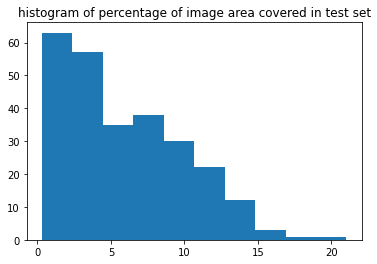

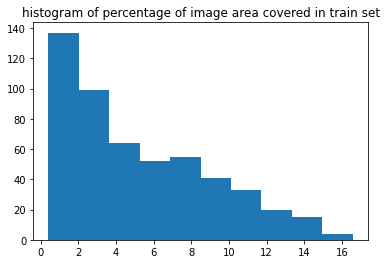

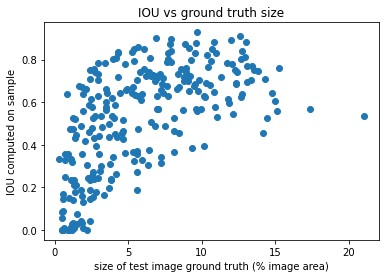

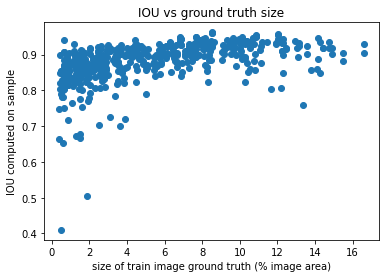

In [ ]:
test_gt_areas_pc = 100*np.mean(ys_test_array, axis=(1, 2, 3))
train_gt_areas_pc = 100*np.mean(ys_sup_array, axis=(1, 2, 3))

plt.figure()
plt.hist(test_gt_areas_pc)
#plt.title('histogram of percentage of image area covered in test set')
plt.title('histogram of percentage of image area covered in val set')
plt.show()

plt.figure()
plt.hist(train_gt_areas_pc)
plt.title('histogram of percentage of image area covered in train set')
plt.show()

plt.figure()
plt.scatter(test_gt_areas_pc, test_epoch_ious)
#plt.xlabel('size of test image ground truth (% image area)')
plt.xlabel('size of val image ground truth (% image area)')
plt.ylabel('IOU computed on sample')
plt.title('IOU vs ground truth size')
plt.show()

plt.figure()
plt.scatter(train_gt_areas_pc, epoch_ious)
plt.xlabel('size of train image ground truth (% image area)')
plt.ylabel('IOU computed on sample')
plt.title('IOU vs ground truth size')
plt.show()